# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

## Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

## Objetivo principal
Identificar a los operadores ineficaces debido a llamadas perdidas, tiempo de espera alto en contestar una llamada o pocas llamdas realizadas a clientes

### Objetivos secundarios

- Establecer la cantidad de llamadas perdidas para ser considerado ineficaz
- Establecer la cantidad de tiempo tomado en responder una llamada para ser considerado ineficaz
- Establecer la cantidad de llamadas realizadas.


In [1]:
# Importanciónde librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

## Descarga de los datos

In [2]:
dataset = pd.read_csv("https://practicum-content.s3.us-west-1.amazonaws.com/datasets/telecom_dataset_us.csv",
                      dtype = {"operator_id" : "object",
                               "user_id": "object",
                              "internal" : "boolean"},
                               parse_dates=['date'])
clients = pd.read_csv("https://practicum-content.s3.us-west-1.amazonaws.com/datasets/telecom_clients_us.csv",
                     dtype = {"user_id": "object"},
                     parse_dates=['date_start'])

In [3]:
# Visualización de los datasets
display(dataset, clients)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


## Preprocesamiento de datos

In [46]:
# Función para revisión de dataset
def revision(data):
    '''
    Función para automatizar la revisión de un dataset
    Se agrega un dataframe como input
    Da una descripción del dataset como output
    '''
    display(data.head())
    print()
    print(data.columns)
    print()
    print(data.info())
    print()
    display(data.describe(include = "all", percentiles = [0.90,0.95,0.99]))
    print("Filas duplicadas: ",data.duplicated().sum())
    print(data.shape)

Documentación:

Los percentiles pueden ser obtenidos en una serie o directamente de la función Describe, el cual da de antemano ciertos percentiles, pero se pueden agregar mas usando el parámetro "percentiles", tal como lo muestra la documentación

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html

### dataset

In [5]:
# revisión del dataset para iniciar el preprocesamiento de datos
revision(dataset)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25



Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration',
       'total_call_duration'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  object                               
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  boolean                              
 4   operator_id          45730 non-null  object                               
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                           

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
count,53902,53902,53902,53785,45730,53902,53902.000000,53902.000000,53902.000000
unique,307,119,2,2,1092,2,NaN,NaN,NaN
top,168187,2019-11-25 00:00:00+03:00,out,False,901884,False,NaN,NaN,NaN
freq,2580,1220,31917,47621,348,30334,NaN,NaN,NaN
first,NaN,2019-08-02 00:00:00+03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-11-28 00:00:00+03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,16.451245,866.684427,1157.133297
std,NaN,NaN,NaN,NaN,NaN,NaN,62.917170,3731.791202,4403.468763
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,38.000000,210.000000


Filas duplicadas:  4900
(53902, 9)


Se observa lo siguiente:
- Los nombres de las columnas están escritos de forma correcta
- Hay valores nulos en las columnas "operator_id" e "internal"
- Antes de analizar el dataset, se eliminarán las filas vacías de la columna "internal" dado que representan menos del 1% de los datos
- Los valores nulos de "operator_id" se eliminarán, representan cerca del 15% de los datos, sin embargo, dado que la intención es identificar a los operadores ineficientes, no se puede hacer un estudio en donde no se conozca que operador está aportando dicha información.
- Se cambiarán las columnas de duración de llamdas a minutos para ser mas sencillo de interpretar
- Al igual, existen 4900 filas duplicadas que deben de ser eliminadas.

#### Eliminación de valores nulos

In [6]:
# Eliminacion de valores nulos para "internal"
dataset = dataset.dropna(subset = ["internal","operator_id"])

#### Eliminación de duplicados

In [7]:
# Eliminacipon de filas duplicadas.
dataset = dataset.drop_duplicates()

### Conversión de tipo de datos y creación de columnas

In [8]:
# Cambio de segundos a minutos en las llamadas.

dataset["call_duration"] = dataset["call_duration"]/60
dataset["total_call_duration"] = dataset["total_call_duration"]/60

# Creación de columna de tiempo de espera
dataset["waiting_time"] = dataset["total_call_duration"] - dataset["call_duration"]

In [9]:
# revisión del dataset para iniciar el preprocesamiento de datos
revision(dataset)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0.000000,0.083333,0.083333
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0.000000,0.016667,0.016667
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,0.166667,0.300000,0.133333
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0.000000,0.416667,0.416667
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,0.050000,0.483333,0.433333



Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration',
       'waiting_time'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 53899
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              41491 non-null  object                               
 1   date                 41491 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            41491 non-null  object                               
 3   internal             41491 non-null  boolean                              
 4   operator_id          41491 non-null  object                               
 5   is_missed_call       41491 non-null  bool                                 
 6   calls_count          41491 non-null  int64          

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
count,41491,41491,41491,41491,41491,41491,41491.000000,41491.000000,41491.000000,41491.000000
unique,290,118,2,2,1092,2,NaN,NaN,NaN,NaN
top,168187,2019-11-25 00:00:00+03:00,out,False,901884,False,NaN,NaN,NaN,NaN
freq,2267,987,28813,36161,323,27382,NaN,NaN,NaN,NaN
first,NaN,2019-08-02 00:00:00+03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-11-28 00:00:00+03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,16.921381,16.849000,22.052554,5.203554
std,NaN,NaN,NaN,NaN,NaN,NaN,59.786187,67.777775,79.815886,19.601716
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,1.766667,4.816667,1.000000


Filas duplicadas:  0
(41491, 10)


Descripción de los datos:
- user_id:
    - Los 41,491 eventos provienen de 307 usuarios.
    - El usuario 168187 realizó el mayor número de llamadas, con 2,267 eventos.
- date:
    - El día con mayor número de eventos fue el 2019-11-25
- direction:
    - Llamadas de tipo "out" tienen la mayor cantidad de eventos, con mas del 50%
- internal
    - Cerca del 90% de las llamadas son de tipo externas.
- operator_id:
    - Hay 1092 operadores distintos.
    - El operador 901884 tiene la mayor cantidad de eventos registrados, con un total de 323 eventos.
- is_missed_call:
    - Cerca del 65% de las llamadas fueron respondidas.
- calls_count:
    - El promedio de llamadas por usuario es de 16, sin embargo el 50% de los datos tiene menos de 5 llamadas y hay una gran desviación estandar, por lo que existen valores atípicos.
- call_duration:
    - Se tiene un promedio de 16 min por llamada, pero con una desviación estandar muy alta, por lo que hay valores atípicos.
- total_call_duration:
    - Se tiene un promedio de 22 min de llamada con una muy grande desviación estandar, por lo que hay valores atípicos.
- waiting_time:
    - Se tiene un promedio de 5 min de tiempo de espera, con una alta desviación estandar.

### clients

In [10]:
# revisión del dataframe para iniciar el preprocesamiento de datos
revision(clients)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16



Index(['user_id', 'tariff_plan', 'date_start'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    object        
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 17.3+ KB
None



,user_id,tariff_plan,date_start
count,732,732,732
unique,732,3,73
top,167645,C,2019-09-24 00:00:00
freq,1,395,24
first,NaN,NaN,2019-08-01 00:00:00
last,NaN,NaN,2019-10-31 00:00:00


Filas duplicadas:  0
(732, 3)


Se observa lo siguiente:
- Los nombres de las columnas están escritos correctamente
- No hay valores nulos en los registros.
- El plan C tiene la mayor cantidad de usuarios.
- La fecha 2019-09-24 es el día con mayor registro de usuarios.

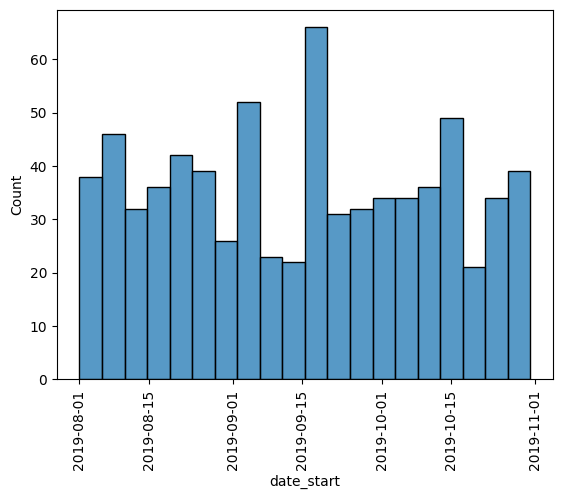

In [11]:
# Distribución de registros por tiempo

sns.histplot(clients["date_start"], bins = 20)
plt.xticks(rotation=90)
plt.show()

## Análisis exploratorio de datos

### Unificacion de DFs

In [12]:
# Unión de datframes con merge.
merge_data = dataset.merge(clients, how = "inner", on = "user_id")

### Visualización de datos

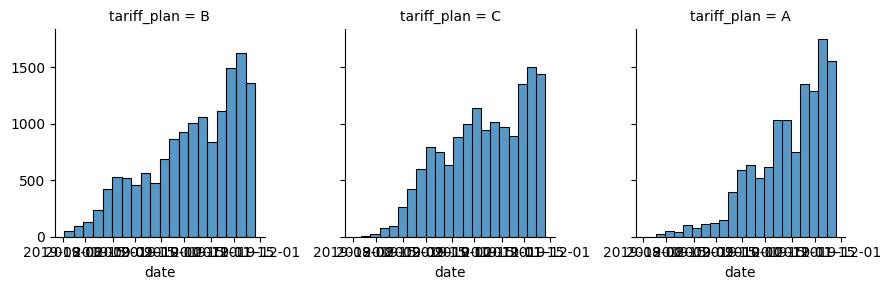

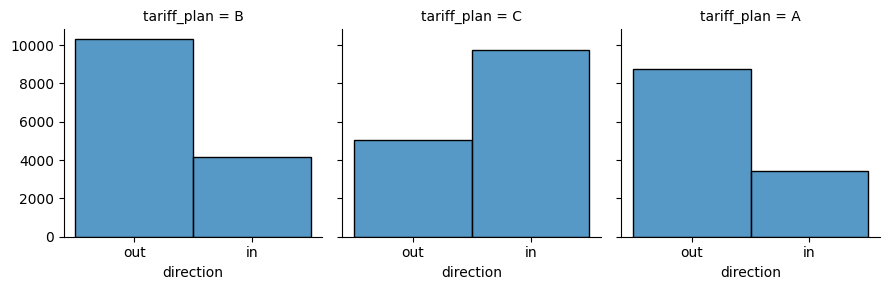

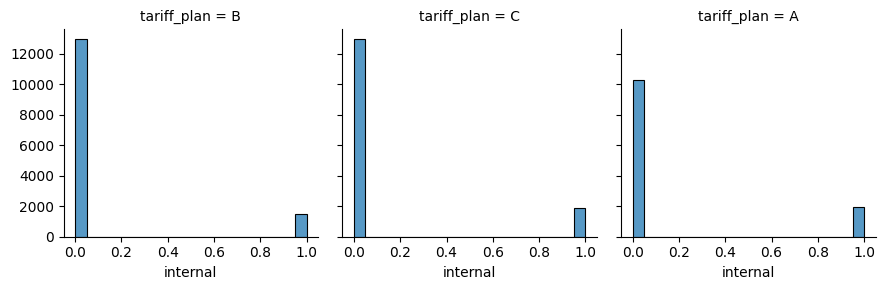

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


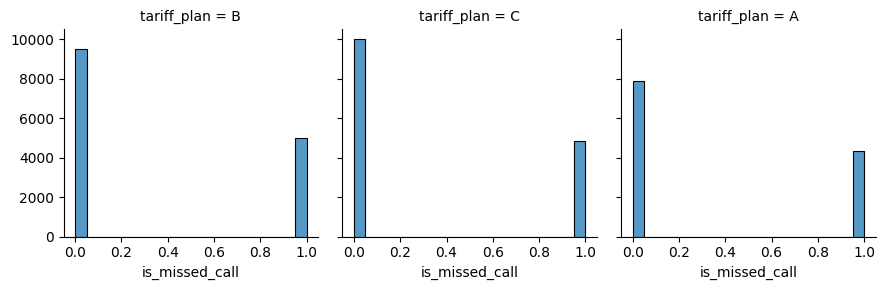

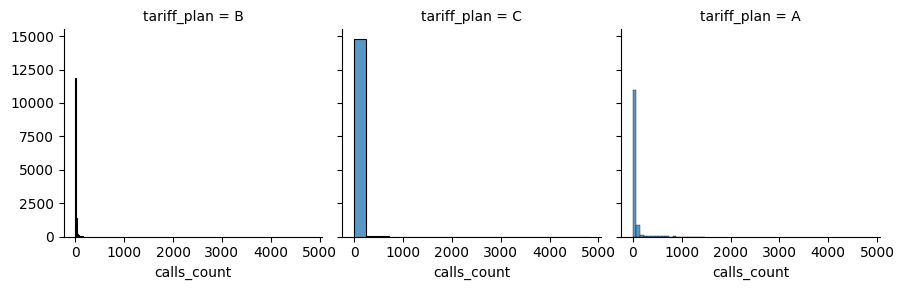

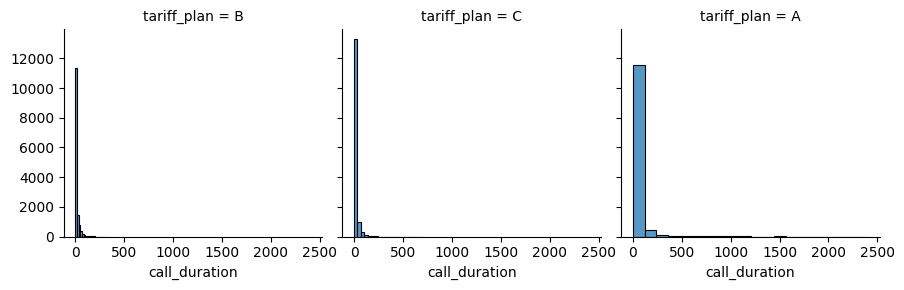

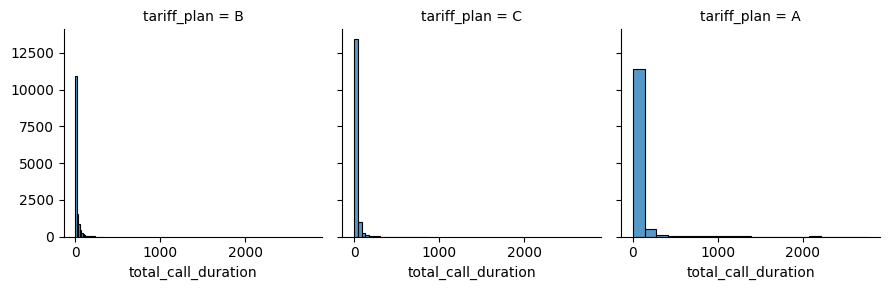

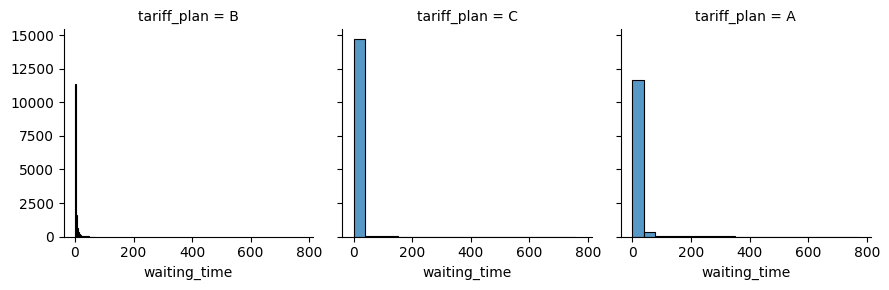

In [48]:
# Distribución de datos por tipo de plan

list = ["date", "direction", "internal", "is_missed_call", "calls_count", "call_duration", "total_call_duration", "waiting_time"]
for feature in list:
    g = sns.FacetGrid(merge_data, col = "tariff_plan")
    g.map(sns.histplot, feature, bins=20)
    plt.show()

Documentación:

En este caso se está usando una visualización gráfica de histogramas por cada una de las características, en un mapa de gráficos, usanado sns.FacetGrid y colocando en el parámetro "col" la categoría de interés para dividir los datos.
Esto se usó de acuerdo a la documentación:
https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

#### Distribución de llamadas perdidas

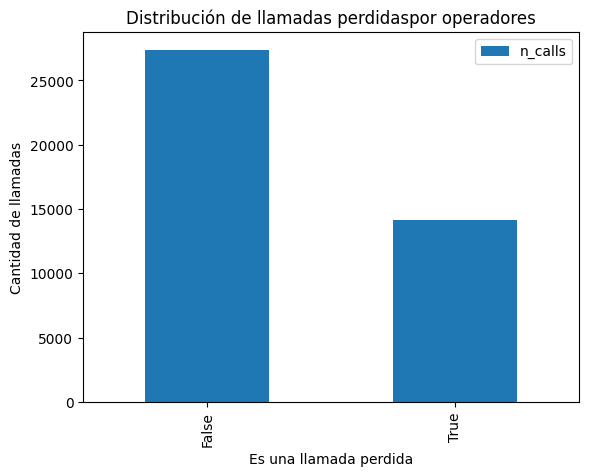

In [14]:
# Separación de llamadas por llamadas perdidas

n_missed_calls = merge_data.groupby("is_missed_call").size().reset_index(name = "n_calls")
n_missed_calls.plot(x = "is_missed_call", kind='bar')
plt.title('Distribución de llamadas perdidaspor operadores')
plt.xlabel('Es una llamada perdida')
plt.ylabel('Cantidad de llamadas')
plt.show()

Se observa que hay una gran cantidad de llamadas respondidas, sin embargo, las llamadas perdidas también representan una cantidad considerable de datos.

Documentación: 

Cuando se usa la función .size() para obtener el tamaño de cada agrupación, se obtiene una nueva columna con nombre "0", esta puede sustituirse directamente desde reset_index() usando el parámetro name()

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html

#### Distribución de tiempos de espera

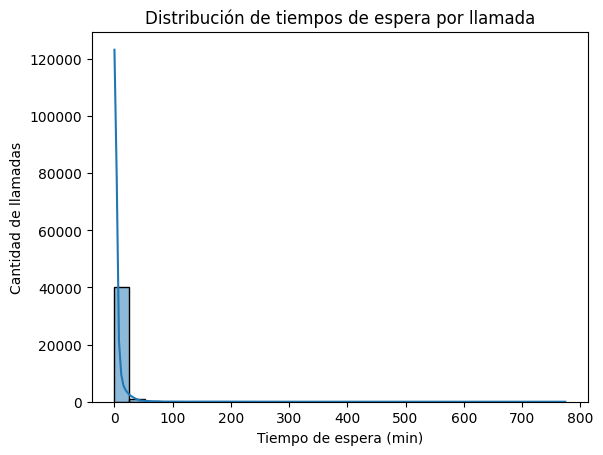

In [15]:
# Histograma para observar el comportamiento de los tiempos de espera

sns.histplot(data = merge_data["waiting_time"], kde = True, bins = 30)
plt.title('Distribución de tiempos de espera por llamada')
plt.xlabel('Tiempo de espera (min)')
plt.ylabel('Cantidad de llamadas')
plt.show()

In [16]:
# Tiempo medio y promedio
mean = merge_data["waiting_time"].mean()
median = merge_data["waiting_time"].median()
print(f"El tiempo promedio de espera es de {mean:.2f} minutos")
print(f"El tiempo medio de espera es de {median:.2f} minutos")
# Obtención de percentil 90
p_90 = np.percentile(merge_data["waiting_time"], 90)
print(f"El 90% de los tiempos de espera se encuentra por debajo de {p_90:.2f} minutos")


El tiempo promedio de espera es de 5.20 minutos
El tiempo medio de espera es de 1.00 minutos
El 90% de los tiempos de espera se encuentra por debajo de 10.98 minutos


Tanto visual como numéricamente (al ser tan diferentes la media y mediana) se oserva que hay valores atípicos.

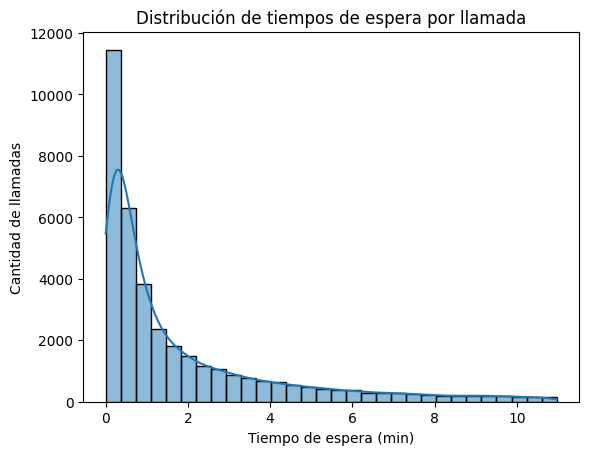

In [17]:
# Histograma para observar el comportamiento de los tiempos de espera menor al percentil 90
,
sns.histplot(data = merge_data[merge_data["waiting_time"] < p_90]["waiting_time"], kde = True, bins = 30)
plt.title('Distribución de tiempos de espera por llamada')
plt.xlabel('Tiempo de espera (min)')
plt.ylabel('Cantidad de llamadas')
plt.show()

#### Distribución de llamadas salientes

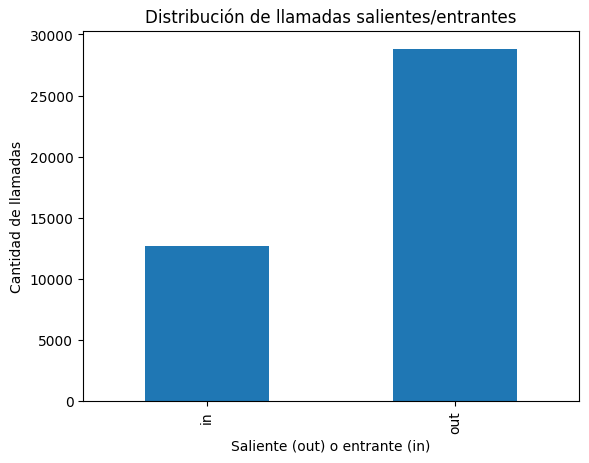

In [18]:
merge_data['direction'].value_counts().sort_values(ascending=True).plot(kind='bar')
plt.title('Distribución de llamadas salientes/entrantes')
plt.xlabel('Saliente (out) o entrante (in)')
plt.ylabel('Cantidad de llamadas')
plt.show()

La gran  mayoría de las llamadas son entrantes, cerca del 30% de las llamadas son entrantes

### Correlación de variables

In [19]:
# Verificación de correlación entre las variables.
# Valor de 0 para llamadas exitosas, 1 para llamadas perdidas.
merge_data['is_missed_call_numerical'] = np.where(merge_data['is_missed_call'] == False, 0, 1)

 # Valor de 0 para llamadas salientes, 1 para llamadas entrantes.
merge_data['direction_numerical'] = np.where(merge_data['direction'] == 'out', 0, 1)
merge_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,tariff_plan,date_start,is_missed_call_numerical,direction_numerical
0,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0.000000,0.083333,0.083333,B,2019-08-01,1,0
1,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0.000000,0.016667,0.016667,B,2019-08-01,1,0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,0.166667,0.300000,0.133333,B,2019-08-01,0,0
3,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0.000000,0.416667,0.416667,B,2019-08-01,1,0
4,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,0.050000,0.483333,0.433333,B,2019-08-01,0,0


Documentación:

El uso de la función np.where() puede ser usado de forma similar a .apply(), sin embargo, para algunos casos where() será mas resumida y eficiente.

https://numpy.org/doc/stable/reference/generated/numpy.where.html

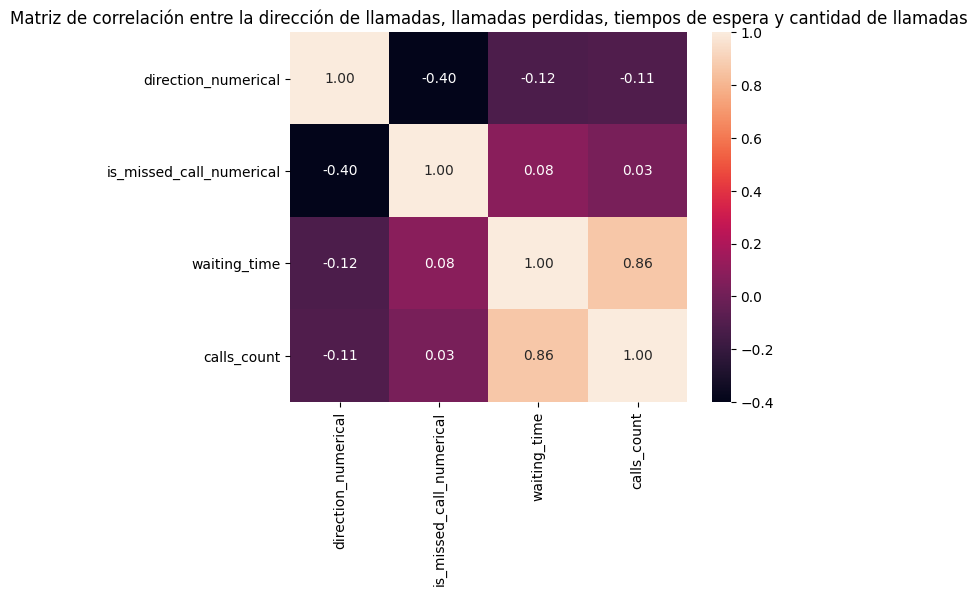

In [20]:
# Creación de matriz de correlación
# Características: "direction_numerical", "is_missed_call_numerical", "waiting_time", "calls_count"

correlation = merge_data[["direction_numerical", "is_missed_call_numerical", "waiting_time", "calls_count"]].corr()

# Mapa de calor para correlaciones:
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.title('Matriz de correlación entre la dirección de llamadas, llamadas perdidas, tiempos de espera y cantidad de llamadas')
plt.show()

Se observa una fuerte correlación entre "waiting_time" y "calls_count", sin embargo, esta correlación era de esperarse, ya que a mayo número de llamdas es mas probable que se tengan tiempos de espera.

### Definición de métricas de evaluación

Recordando las características a evaluar para criterio.
Se considera que un operador es ineficiente si:
- Tiene muchas llamadas perdidas.
- Altos tiempos de espera
- Realiza pocas llamadas.

#### Llamadas perdidas

In [21]:
# Dataframe con solo llamadas perdidas
missed_calls = merge_data[merge_data["is_missed_call_numerical"] == 1]

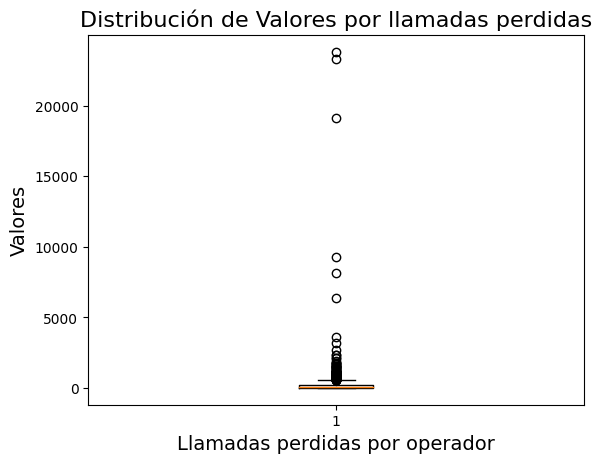

In [22]:
# Gráfico de caja y bigotes de llamdas perdidas por operador
missed_calls_per_operator = missed_calls.groupby("operator_id")["calls_count"].sum().reset_index()
plt.boxplot(missed_calls_per_operator["calls_count"])
plt.title("Distribución de Valores por llamadas perdidas", fontsize=16)
plt.xlabel("Llamadas perdidas por operador", fontsize=14)
plt.ylabel("Valores", fontsize=14)
plt.show()

##### Rango interquartil para llamadas perdidas

In [23]:
# Obtención de métricas para "is_missed_call".
# Se usará el rango intercuartil para obtener los valores atipicos, los cuales serán usados para definir la ineficiencia.

# Q1 + (1.5 * IQR)
Q1 = np.percentile(missed_calls_per_operator["calls_count"], 25)
Q3 = np.percentile(missed_calls_per_operator["calls_count"], 75)
IQR = Q3 - Q1
limit_missed_calls = Q1 + (1.5 * IQR)
print(f"Se considerará ineficiente si el operador tiene un total de llamadas perdidas mayor a {limit_missed_calls:.0f} llamadas")

Se considerará ineficiente si el operador tiene un total de llamadas perdidas mayor a 340 llamadas


Documentación:

El rango inerquartil ayuda a establecer un valor o límite a una cantidad de datos, de esta forma se puede establecer cuando un valor es atípico de forma objetiva, esto evita que se elija un quartil para la decisión.

https://online.stat.psu.edu/stat200/lesson/3/3.2

#### Waiting time

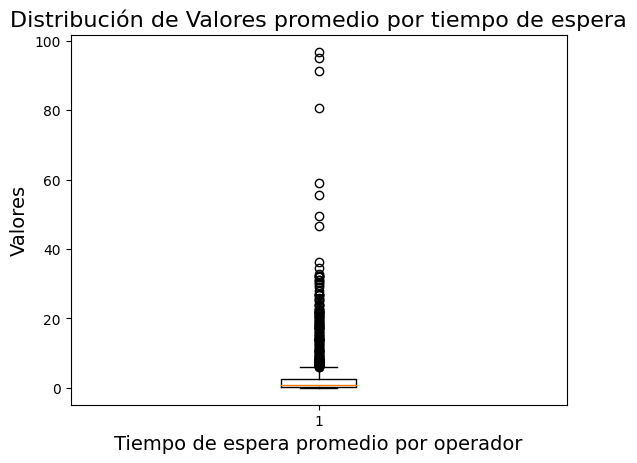

In [24]:
# Cálculo promedio de tiempos de espera por operador
mean_waiting_time_per_operator = merge_data.groupby("operator_id")["waiting_time"].mean().reset_index()
mean_waiting_time_per_operator.columns = ["operator_id", "mean_waiting_time"]

# Gráfico de caja y bigotes para visualizar la distribución promedio
plt.boxplot(mean_waiting_time_per_operator["mean_waiting_time"])
plt.title("Distribución de Valores promedio por tiempo de espera", fontsize=16)
plt.xlabel("Tiempo de espera promedio por operador", fontsize=14)
plt.ylabel("Valores", fontsize=14)
plt.show()

##### Rango interquartil para waiting_time

In [25]:
# Obtención de métricas para "waiting_time".
# Se usará el rango intercuartil para obtener los valores atipicos, los cuales serán usados para definir la ineficiencia.

# Q1 + (1.5 * IQR)
Q1 = np.percentile(mean_waiting_time_per_operator["mean_waiting_time"], 25)
Q3 = np.percentile(mean_waiting_time_per_operator["mean_waiting_time"], 75)
IQR = Q3 - Q1
limit_time = Q1 + (1.5 * IQR)
print(f"Se considerará ineficiente si el operador tiene un tiempo promedio de espera mayor a {limit_time:.2f} minutos")

Se considerará ineficiente si el operador tiene un tiempo promedio de espera mayor a 3.80 minutos


#### Llamadas externas realizadas

In [26]:
# Obtención de Dataframe de llamadas realizadas
out_calls =dataset[dataset["direction"] == "out"]

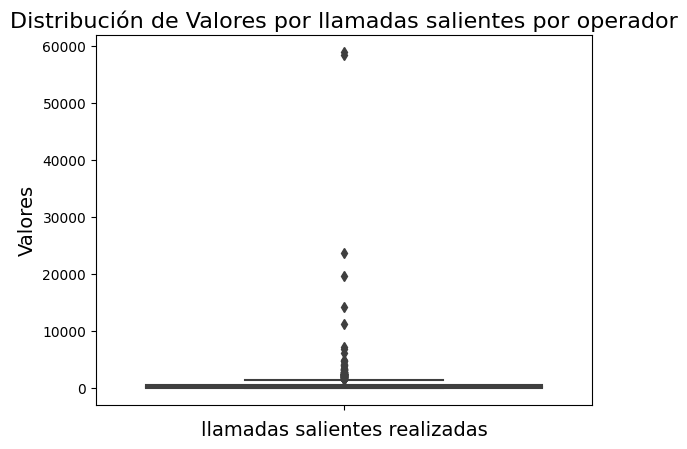

,calls_count
count,882.000000
mean,689.731293
std,3122.953946
min,1.000000
25%,11.000000
50%,90.000000
75%,597.250000
max,58977.000000


In [27]:
# Agrupación y visualización de los datos

out_calls_per_operator = out_calls.groupby("operator_id")["calls_count"].sum().reset_index()
sns.boxplot(data = out_calls_per_operator, y = "calls_count")
plt.title("Distribución de Valores por llamadas salientes por operador", fontsize=16)
plt.xlabel("llamadas salientes realizadas", fontsize=14)
plt.ylabel("Valores", fontsize=14)
plt.show()

display(out_calls_per_operator.describe())

In [28]:
# Obtención de métricas para "llamadas salientes".
# Se considerará ineficiente a los operadores que tengan menos llamadas que el percetnil 10 de los operadores 

limit_calls = np.percentile(out_calls_per_operator["calls_count"], 10)
print(f"Se considerará ineficiente si el operador tiene menos de {limit_calls:.0f} llamadas externas salientes")

Se considerará ineficiente si el operador tiene menos de 3 llamadas externas salientes


### Métricas de ineficiencia

Métricas obtenidas de ineficiencia:
Se considerará ineficiente si cumple con:
- Más de 340 llamadas perdidas
- Mas de 3.8 minutos promedio de espera
- Menos de 3 llamadas salientes

## Identificación de operadores ineficientes

In [29]:
# Lista de operadores únicos
events_operators_id = merge_data["operator_id"].unique()
operators_id = pd.DataFrame({"operator_id":events_operators_id})

# Unión con df de llamadas perdidas
merge_1 = operators_id.merge(missed_calls_per_operator, how = "left", on = "operator_id")

# Unión con df de waiting_time
merge_2 =merge_1.merge(mean_waiting_time_per_operator, how = "left", on = "operator_id")

# Unión con df de llamdas salientes por operador
total_data = merge_2.merge(out_calls_per_operator, how = "left", on = "operator_id")
total_data.columns = ["operator_id", "missed_calls", "mean_waiting_time", "n_out_calls"]
total_data

,operator_id,missed_calls,mean_waiting_time,n_out_calls
0,880022,105.0,0.899524,189.0
1,880020,22.0,0.233333,38.0
2,881278,17.0,0.162500,20.0
3,880028,993.0,3.502970,2497.0
4,880026,648.0,2.032967,2208.0
...,...,...,...,...
1087,958394,NaN,0.279630,NaN
1088,952914,246.0,3.175510,580.0
1089,952916,1.0,0.666667,7.0
1090,959118,4.0,0.783333,14.0


In [30]:
# Métricas
llamadas_perdidas = 340
tiempo_de_espera = 3.8
llamadas_salientes = 3


# Creación de columas que identifique la ineficiencia por métrica
# En donde False se usará como Eficiencia y True como Ineficiencia

total_data["is_missed_call_inefficiency"] = (
    total_data.apply(lambda x: True if x["missed_calls"] > llamadas_perdidas else False, axis = 1)
)

total_data["mean_waiting_time_inefficiency"] = (
    total_data.apply(lambda x: True if x["mean_waiting_time"] > tiempo_de_espera else False, axis = 1)
)

total_data["n_out_calls_inefficiency"] = (
    total_data.apply(lambda x: True if x["n_out_calls"] < llamadas_salientes else False, axis = 1)
)

total_data

,operator_id,missed_calls,mean_waiting_time,n_out_calls,is_missed_call_inefficiency,mean_waiting_time_inefficiency,n_out_calls_inefficiency
0,880022,105.0,0.899524,189.0,False,False,False
1,880020,22.0,0.233333,38.0,False,False,False
2,881278,17.0,0.162500,20.0,False,False,False
3,880028,993.0,3.502970,2497.0,True,False,False
4,880026,648.0,2.032967,2208.0,True,False,False
...,...,...,...,...,...,...,...
1087,958394,NaN,0.279630,NaN,False,False,False
1088,952914,246.0,3.175510,580.0,False,False,False
1089,952916,1.0,0.666667,7.0,False,False,False
1090,959118,4.0,0.783333,14.0,False,False,False


Hay 175 operadores ineficicentes por llamadas perdidas
Hay 214 operadores ineficicentes por tiempo de espera
Hay 88 operadores ineficicentes por llamadas salientes


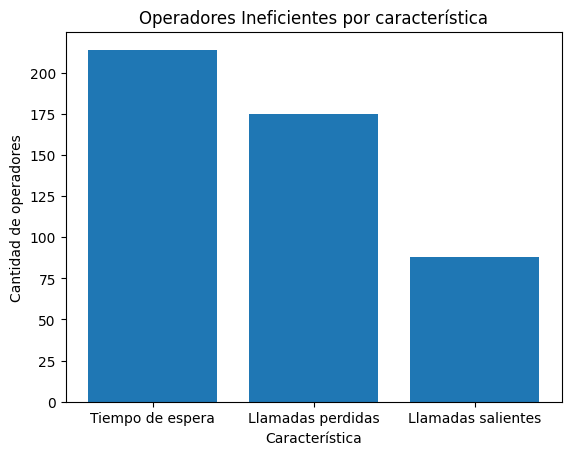

In [31]:
# Cantidad de operadores ineficientes por característica
n_is_missed_call_inefficiency = len(total_data[total_data["is_missed_call_inefficiency"] == True])
n_mean_waiting_time_inefficiency = len(total_data[total_data["mean_waiting_time_inefficiency"] == True])
n_n_out_calls_inefficiency = len(total_data[total_data["n_out_calls_inefficiency"] == True])

print(f"Hay {n_is_missed_call_inefficiency} operadores ineficicentes por llamadas perdidas")
print(f"Hay {n_mean_waiting_time_inefficiency} operadores ineficicentes por tiempo de espera")
print(f"Hay {n_n_out_calls_inefficiency} operadores ineficicentes por llamadas salientes")

n_oper_ineficient_per_metric = pd.DataFrame({"caracteristica":["Llamadas perdidas","Tiempo de espera","Llamadas salientes"],
                                 "n_operadores":[n_is_missed_call_inefficiency,n_mean_waiting_time_inefficiency, n_n_out_calls_inefficiency]}).sort_values(by = "n_operadores", ascending = False)


plt.bar(n_oper_ineficient_per_metric["caracteristica"], n_oper_ineficient_per_metric["n_operadores"])
plt.title('Operadores Ineficientes por característica')
plt.xlabel('Característica')
plt.ylabel('Cantidad de operadores')
plt.show()

In [32]:
# Sumar los valores True en las últimas tres columnas para cada operador
total_data['inefficiency_count'] = total_data[['is_missed_call_inefficiency', 'mean_waiting_time_inefficiency', 'n_out_calls_inefficiency']].sum(axis=1)

# Operadores que tienen al menos 1 Ineficicencia
inefficient_operators_1 = total_data[total_data['inefficiency_count'] >= 1]['operator_id'].unique()
print(f"Hay {len(inefficient_operators_1)} operadores con al menos 1 ineficicencia")
print("Operadores con al menos 1 ineficiencias:", inefficient_operators_1)
print()


# Operadores que tienen al menos 2 Ineficicencias
inefficient_operators_2 = total_data[total_data['inefficiency_count'] >= 2]['operator_id'].unique()
print(f"Hay {len(inefficient_operators_2)} operadores con al menos 2 ineficicencias")
print("Operadores con al menos 2 ineficiencias:", inefficient_operators_2)
print()


# Operadores que tienen al menos 3 Ineficicencias
inefficient_operators_3 = total_data[total_data['inefficiency_count'] >= 3]['operator_id'].unique()
print(f"Hay {len(inefficient_operators_3)} operadores con al menos 3 ineficicencias")
print("Operadores con al menos 3 ineficiencias:", inefficient_operators_3)

Hay 331 operadores con al menos 1 ineficicencia
Operadores con al menos 1 ineficiencias: ['880028' '880026' '882478' '882686' '902510' '882690' '939470' '939476'
 '879898' '887282' '907174' '906866' '883940' '883942' '883018' '883898'
 '891410' '891414' '884946' '890234' '892028' '893674' '891192' '930510'
 '884478' '900192' '908834' '885890' '885876' '925922' '890404' '890406'
 '890416' '890402' '890412' '890410' '900892' '917234' '919418' '932502'
 '932500' '932498' '943050' '954642' '960294' '972410' '899082' '891250'
 '891918' '889754' '891976' '895266' '893804' '899250' '900180' '954318'
 '903254' '902720' '895598' '917890' '894656' '928282' '928284' '955094'
 '955068' '955086' '910594' '896382' '896386' '914626' '901884' '901880'
 '901886' '903318' '905432' '905430' '909502' '899788' '899932' '899968'
 '899790' '899964' '899076' '962904' '910530' '923526' '903292' '913938'
 '913942' '963716' '907998' '904016' '904014' '951648' '902238' '901992'
 '902746' '902782' '902742' '902744

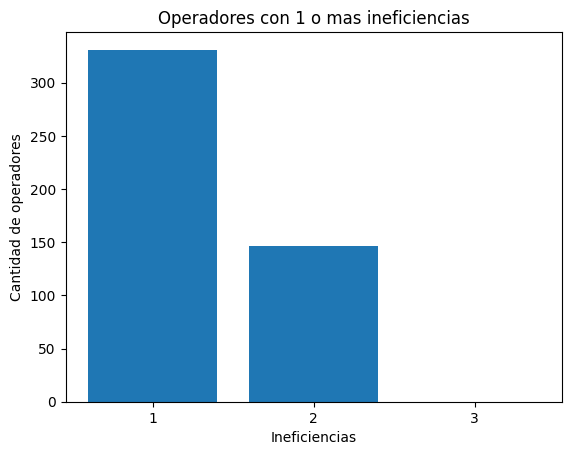

In [33]:
# Gráfico de operadores con ineficicencias

n_oper_ineficient = pd.DataFrame({"n_areas_ineficiencia":["1","2","3"],
                                 "n_operadores":[len(inefficient_operators_1),len(inefficient_operators_2), len(inefficient_operators_3)]})
n_oper_ineficient


plt.bar(n_oper_ineficient["n_areas_ineficiencia"], n_oper_ineficient["n_operadores"])
plt.title('Operadores con 1 o mas ineficiencias')
plt.xlabel('Ineficiencias')
plt.ylabel('Cantidad de operadores')
plt.show()


De las 3 áreas a evaluar, no existe algun operador que sea ineficiente en las 3. Sin embargo mas de 300 operadores son ineficientes en al menos un área, lo cual representa el 30% de los operadores.

## Pruebas de hipótesis

### Los operadores ineficientes en llamadas perdidas tienen un comportamiento parecido para llamadas salientes, en comparación con los operadores ineficientes en tiempos de espera

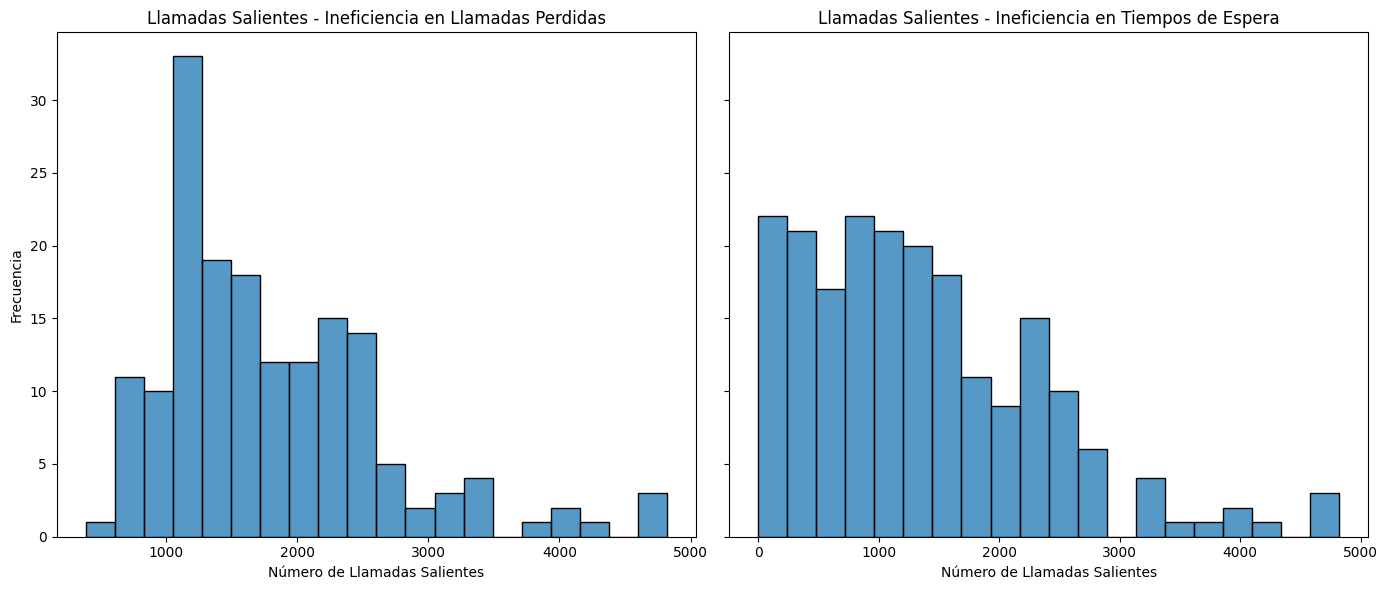

In [34]:
# Distribución de los datos
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Llamadas salientes de operadores ineficientes en llamadas perdidas, considerando valores menores al percentil 95
out_calls_oper_missed_call = total_data[(total_data["is_missed_call_inefficiency"] == True) & (total_data["n_out_calls"] < 5215)]["n_out_calls"]
sns.histplot(out_calls_oper_missed_call, bins=20, ax=axes[0])
axes[0].set_title("Llamadas Salientes - Ineficiencia en Llamadas Perdidas")
axes[0].set_xlabel("Número de Llamadas Salientes")
axes[0].set_ylabel("Frecuencia")

# Llamadas salientes de operadores ineficientes en tiempos de espera, considerando valores menores al percentil 95
out_calls_oper_waiting_time = total_data[(total_data["mean_waiting_time_inefficiency"] == True) & (total_data["n_out_calls"] < 5215)]["n_out_calls"]
sns.histplot(out_calls_oper_waiting_time, bins=20, ax=axes[1])
axes[1].set_title("Llamadas Salientes - Ineficiencia en Tiempos de Espera")
axes[1].set_xlabel("Número de Llamadas Salientes")

plt.tight_layout()
plt.show()

In [35]:
# Test de shapiro para evaluar si "out_calls_oper_missed_call" tiene distribución normal
p_value = shapiro(out_calls_oper_missed_call)[1]

print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula: la muestra tiene una distribución normal")
else:
    print("Se rechaza la hipótesis nula: la muestra no tiene una distribución normal")

Valor p: 6.761644577579773e-09
Se rechaza la hipótesis nula: la muestra no tiene una distribución normal


In [36]:
# Test de shapiro para evaluar si "out_calls_oper_waiting_time" tiene distribución normal
p_value = shapiro(out_calls_oper_waiting_time)[1]

print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula: la muestra tiene una distribución normal")
else:
    print("Se rechaza la hipótesis nula: la muestra no tiene una distribución normal")

Valor p: 3.6478489562341565e-08
Se rechaza la hipótesis nula: la muestra no tiene una distribución normal


Las muestras no tienen una distribución normal, por lo que se realizará una prueba de mannwhitneyu

In [37]:
p_value = mannwhitneyu(out_calls_oper_missed_call, out_calls_oper_waiting_time, alternative='two-sided')[1]

# Muestra los resultados
alpha = 0.05

print("Valor p:", p_value)

if p_value < alpha:
    print("Se rechaza la hipótesis nula: hay una diferencia significativa entre las medianas de las muestras.")
else:
    print("No se rechaza la hipótesis nula: no hay una diferencia significativa entre las medianas de las muestras.")

Valor p: 3.35873207971604e-07
Se rechaza la hipótesis nula: hay una diferencia significativa entre las medianas de las muestras.


Los operadores que son ineficientes en llamadas perdidas, tienen un comportamiento distinto en llamadas salientes respecto los operadores que son ineficientes en tiempos de espera.

### Los operadores ineficientes en llamadas perdidas tienen un comportamiento parecido para tiempos de espera, en comparación con los operadores ineficientes en llamadas salientes

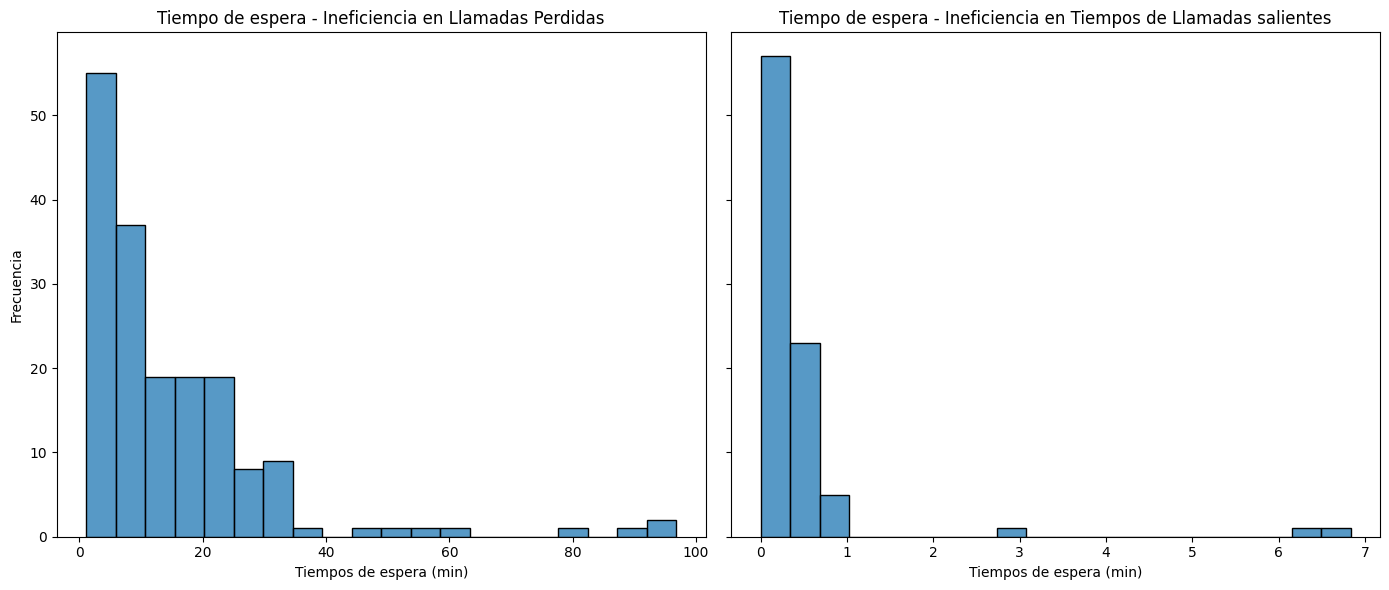

In [38]:
# Distribución de los datos
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Tiempos de espera de operadores ineficientes en llamadas perdidas
waiting_time_oper_missed_call = total_data[total_data["is_missed_call_inefficiency"] == True]["mean_waiting_time"]
sns.histplot(waiting_time_oper_missed_call, bins=20, ax=axes[0])
axes[0].set_title("Tiempo de espera - Ineficiencia en Llamadas Perdidas")
axes[0].set_xlabel("Tiempos de espera (min)")
axes[0].set_ylabel("Frecuencia")

# Tiempos de espera de operadores ineficientes en llamadas salientes
waiting_time_oper_out_calls = total_data[total_data["n_out_calls_inefficiency"] == True]["mean_waiting_time"]
sns.histplot(waiting_time_oper_out_calls, bins=20, ax=axes[1])
axes[1].set_title("Tiempo de espera - Ineficiencia en Tiempos de Llamadas salientes")
axes[1].set_xlabel("Tiempos de espera (min)")

plt.tight_layout()
plt.show()

In [39]:
# Test de shapiro para evaluar si "waiting_time_oper_missed_call" tiene distribución normal
p_value = shapiro(waiting_time_oper_missed_call)[1]

print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula: la muestra tiene una distribución normal")
else:
    print("Se rechaza la hipótesis nula: la muestra no tiene una distribución normal")

Valor p: 2.103453461528855e-17
Se rechaza la hipótesis nula: la muestra no tiene una distribución normal


In [40]:
# Test de shapiro para evaluar si "waiting_time_oper_out_calls" tiene distribución normal
p_value = shapiro(waiting_time_oper_out_calls)[1]

print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula: la muestra tiene una distribución normal")
else:
    print("Se rechaza la hipótesis nula: la muestra no tiene una distribución normal")

Valor p: 5.034583099515718e-18
Se rechaza la hipótesis nula: la muestra no tiene una distribución normal


Las muestras no tienen una distribución normal, por lo que se realizará una prueba de mannwhitneyu

In [41]:
p_value = mannwhitneyu(waiting_time_oper_missed_call, waiting_time_oper_out_calls, alternative='two-sided')[1]

# Muestra los resultados
alpha = 0.05

print("Valor p:", p_value)

if p_value < alpha:
    print("Se rechaza la hipótesis nula: hay una diferencia significativa entre las medianas de las muestras.")
else:
    print("No se rechaza la hipótesis nula: no hay una diferencia significativa entre las medianas de las muestras.")

Valor p: 1.804506741104255e-38
Se rechaza la hipótesis nula: hay una diferencia significativa entre las medianas de las muestras.


Los operadores que son ineficientes en llamadas perdidas, tienen un comportamiento distinto en tiempos de espera respecto los operadores que son ineficientes en llamadas salientes.

### Los operadores ineficientes en tiempos de espera tienen un comportamiento parecido para llamadas perdidas, en comparación con los operadores ineficientes en llamadas salientes

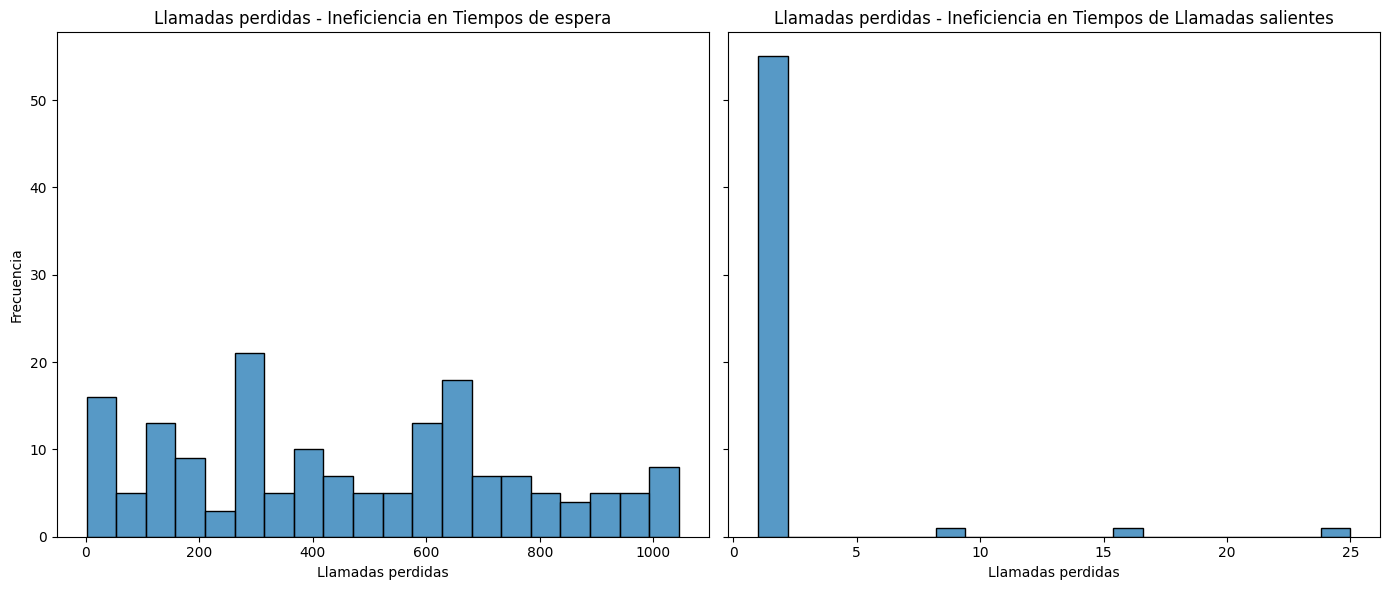

In [42]:
# Distribución de los datos
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Llamadas perdidas de operadores ineficientes en tiempos de esperas, considerando valores menores al percentil 95
missed_calls_oper_missed_call = total_data[(total_data["mean_waiting_time_inefficiency"] == True) & (total_data["missed_calls"] < 1047)]["missed_calls"]
sns.histplot(missed_calls_oper_missed_call, bins=20, ax=axes[0])
axes[0].set_title("Llamadas perdidas - Ineficiencia en Tiempos de espera")
axes[0].set_xlabel("Llamadas perdidas")
axes[0].set_ylabel("Frecuencia")

# Llamadas salientes de operadores ineficientes en tiempos de espera, considerando valores menores al percentil 95
missed_calls_oper_out_calls = total_data[(total_data["n_out_calls_inefficiency"] == True) & (total_data["missed_calls"] < 1047)]["missed_calls"]
sns.histplot(missed_calls_oper_out_calls, bins=20, ax=axes[1])
axes[1].set_title("Llamadas perdidas - Ineficiencia en Tiempos de Llamadas salientes")
axes[1].set_xlabel("Llamadas perdidas")

plt.tight_layout()
plt.show()

In [43]:
# Test de shapiro para evaluar si "missed_calls_oper_missed_call" tiene distribución normal
p_value = shapiro(missed_calls_oper_missed_call)[1]

print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula: la muestra tiene una distribución normal")
else:
    print("Se rechaza la hipótesis nula: la muestra no tiene una distribución normal")

Valor p: 4.345610796008259e-05
Se rechaza la hipótesis nula: la muestra no tiene una distribución normal


In [44]:
# Test de shapiro para evaluar si "missed_calls_oper_out_calls" tiene distribución normal
p_value = shapiro(missed_calls_oper_out_calls)[1]

print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula: la muestra tiene una distribución normal")
else:
    print("Se rechaza la hipótesis nula: la muestra no tiene una distribución normal")

Valor p: 2.980541864139037e-15
Se rechaza la hipótesis nula: la muestra no tiene una distribución normal


Las muestras no tienen una distribución normal, por lo que se realizará una prueba de mannwhitneyu

In [45]:
p_value = mannwhitneyu(missed_calls_oper_missed_call, missed_calls_oper_out_calls, alternative='two-sided')[1]

# Muestra los resultados
alpha = 0.05

print("Valor p:", p_value)

if p_value < alpha:
    print("Se rechaza la hipótesis nula: hay una diferencia significativa entre las medianas de las muestras.")
else:
    print("No se rechaza la hipótesis nula: no hay una diferencia significativa entre las medianas de las muestras.")

Valor p: 1.7493142931526023e-29
Se rechaza la hipótesis nula: hay una diferencia significativa entre las medianas de las muestras.


## Conclusiones

Los datos iniciales muestran valores bastante atípicos, sin embargo, no se eliminaron para poder obtener las métricas correspondientes.

Las métricas establecidas para definir si un operador es ineficiente fueron las siguientes:
Se considerará ineficiente si cumple con al menos 2 de las 3 métricas:
- Más de 340 llamadas perdidas
- Mas de 3.8 minutos promedio de espera
- Menos de 3 llamadas salientes

Considerando las métricas anteriores, se obtuvo que:
- Hay 175 operadores ineficicentes por llamadas perdidas
- Hay 214 operadores ineficicentes por tiempo de espera
- Hay 88 operadores ineficicentes por llamadas salientes

Por tanto puede haber operadores que sean ineficientes en mas de una métrica_
- Hay 331 operadores que son ineficientes en al menos una métrica.
- Hay 146 operadores que son ineficientes en al menos dos métricas.
- No hay operadores que sean ineficientes en las 3 métricas.

De los 1,092 operadores que hay 331 operadores que son ineficientes es al menos una métrica, esto representa el 30% del personal, por lo que se tiene que poner atención en la causa raíz, recomendariía comenzar a enfocarse en el tiempo de espera, que es donde mas se presentan las ineficiencias, posteriormente a los operadores con mas llamadas perdidas y finalmente los operadores con menos llamadas salientes.

Saber la causa raíz y realizar acciones para mejorar el rendimiento de los operadores puede ayudar a disminuir el índice de ineficiiencias presentadas.

Por otro lado, las hipótesis nos muestran que operadores ineficientes de dos métrcias distintas, presenten un comportamiento similar para la 3ra métrica.